In [1]:
import sys
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


# Notebook display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Project root + ensure src on path
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.append(str(project_root / "src"))

## Objective

The objective of this project is to build a scalable machine learning pipeline to predict **accident severity** using the US Accidents dataset (~7.7M records).

This is a **highly imbalanced, large-scale, multi-class classification problem** where:
- Severity levels are ordinal (1 = least severe, 4 = most severe)
- Minority classes (1 and 4) are rare but **business-critical**
- Memory efficiency and scalability are key constraints

The focus is not just accuracy, but **recall for high-severity accidents**, which is more important for real-world safety and response systems.


#### Data Loading

In [2]:
FULL = project_root / "data" / "US_Accidents_March23.csv"

if not FULL.exists():
    raise FileNotFoundError(f"Full CSV not found at {FULL}. Place full dataset there and retry.")

data_df = pd.read_csv(FULL, low_memory=False)
data_df.shape

(7728394, 46)

In [3]:
data_df.columns = [str(c).strip() for c in data_df.columns]

In [4]:
display(data_df.head(10))

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,Dayton,Montgomery,OH,45417-2476,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,Accident on I-75 Southbound at Exit 54B Grand ...,N Main St,Dayton,Montgomery,OH,45405,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,Accident on Notre Dame Ave at Warner Ave. Expe...,Notre Dame Ave,Dayton,Montgomery,OH,45404-1923,US,US/Eastern,KFFO,2016-02-08 07:58:00,33.3,NaN,99.0,29.67,5.0,SW,1.2,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,Right hand shoulder blocked due to accident on...,Westerville Rd,Westerville,Franklin,OH,43081

#### Descriptive Statitics

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [6]:
display(data_df.describe(include=[np.number]).T)

,count,mean,std,min,25%,50%,75%,max
Severity,7728394.0,2.212384,0.487531,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,7728394.0,36.201195,5.076079,24.554800,33.399631,35.823974,40.084959,49.002201
Start_Lng,7728394.0,-94.702545,17.391756,-124.623833,-117.219396,-87.766616,-80.353676,-67.113167
End_Lat,4325632.0,36.261829,5.272905,24.566013,33.462070,36.183495,40.178920,49.075000
End_Lng,4325632.0,-95.725570,18.107928,-124.545748,-117.754345,-88.027890,-80.247086,-67.109242
Distance(mi),7728394.0,0.561842,1.776811,0.000000,0.000000,0.030000,0.464000,441.750000
Temperature(F),7564541.0,61.663286,19.013653,-89.000000,49.000000,64.000000,76.000000,207.000000
Wind_Chill(F),5729375.0,58.251048,22.389832,-89.000000,43.000000,62.000000,75.000000,207.000000
Humidity(%),7554250.0,64.831041,22.820968,1.000000,48.000000,67.000000,84.000000,100.000000
Pressure(in),7587715.0,29.538986,1.006190,0.000000,29.370000,29.860000,30.030000,58.630000


In [7]:
display(data_df.describe(include=[object]).T)

,count,unique,top,freq
ID,7728394,7728394,A-1,1
Source,7728394,3,Source1,4325632
Start_Time,7728394,6131796,2021-01-26 16:16:13,225
End_Time,7728394,6705355,2021-11-22 08:00:00,112
Description,7728389,3761578,A crash has occurred causing no to minimum del...,9593
Street,7717525,336306,I-95 N,78430
City,7728141,13678,Miami,186917
County,7728394,1871,Los Angeles,526851
State,7728394,49,CA,1741433
Zipcode,7726479,825094,91761,11247


In [8]:
missing_cnt = data_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_cnt / len(data_df) * 100).round(3)
missing_df = pd.concat([missing_cnt, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_percent']
display(missing_df.head(30))

,missing_count,missing_percent
End_Lat,3402762,44.029
End_Lng,3402762,44.029
Precipitation(in),2203586,28.513
Wind_Chill(F),1999019,25.866
Wind_Speed(mph),571233,7.391
Visibility(mi),177098,2.292
Wind_Direction,175206,2.267
Humidity(%),174144,2.253
Weather_Condition,173459,2.244
Temperature(F),163853,2.120


#### Null Values

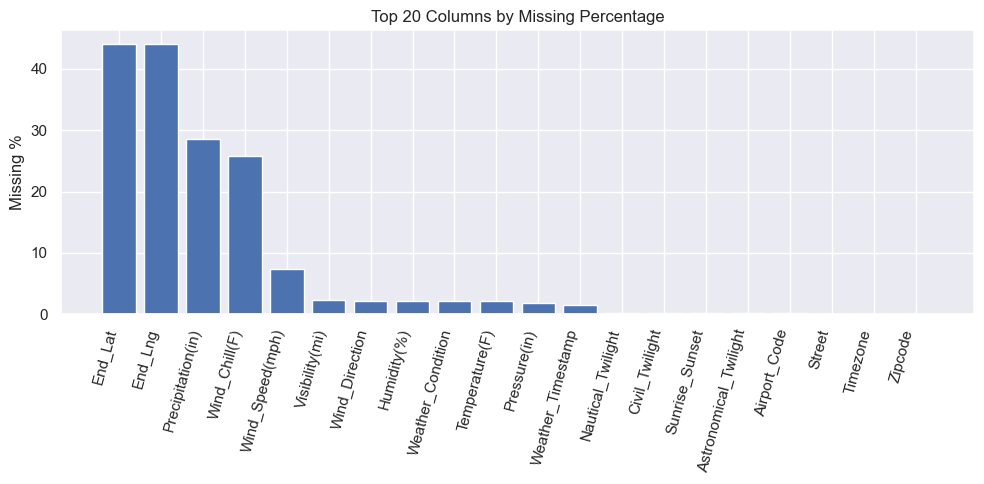

In [9]:
top_missing = missing_df.head(20)
plt.figure(figsize=(10,5))
plt.bar(top_missing.index.astype(str), top_missing['missing_percent'])
plt.xticks(rotation=75, ha='right')
plt.ylabel('Missing %')
plt.title('Top 20 Columns by Missing Percentage')
plt.tight_layout()
plt.show()

#### Target distribution

Detected target column: Severity


Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

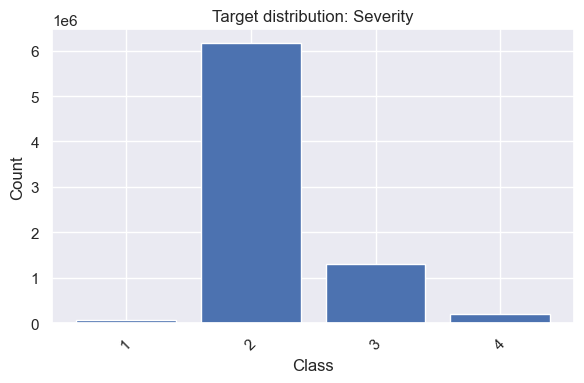

In [10]:
possible_targets = [c for c in data_df.columns if c.lower() in ('severity','severity_id','injury_severity','accident_severity')]
if len(possible_targets) > 0:
    target_col = possible_targets[0]
    print(f"Detected target column: {target_col}")
    vc = data_df[target_col].value_counts(dropna=False).sort_index()
    display(vc)
    plt.figure(figsize=(6,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f'Target distribution: {target_col}')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    target_col = None
    print("No Severity-like target column detected.")

#### Numeric histograms

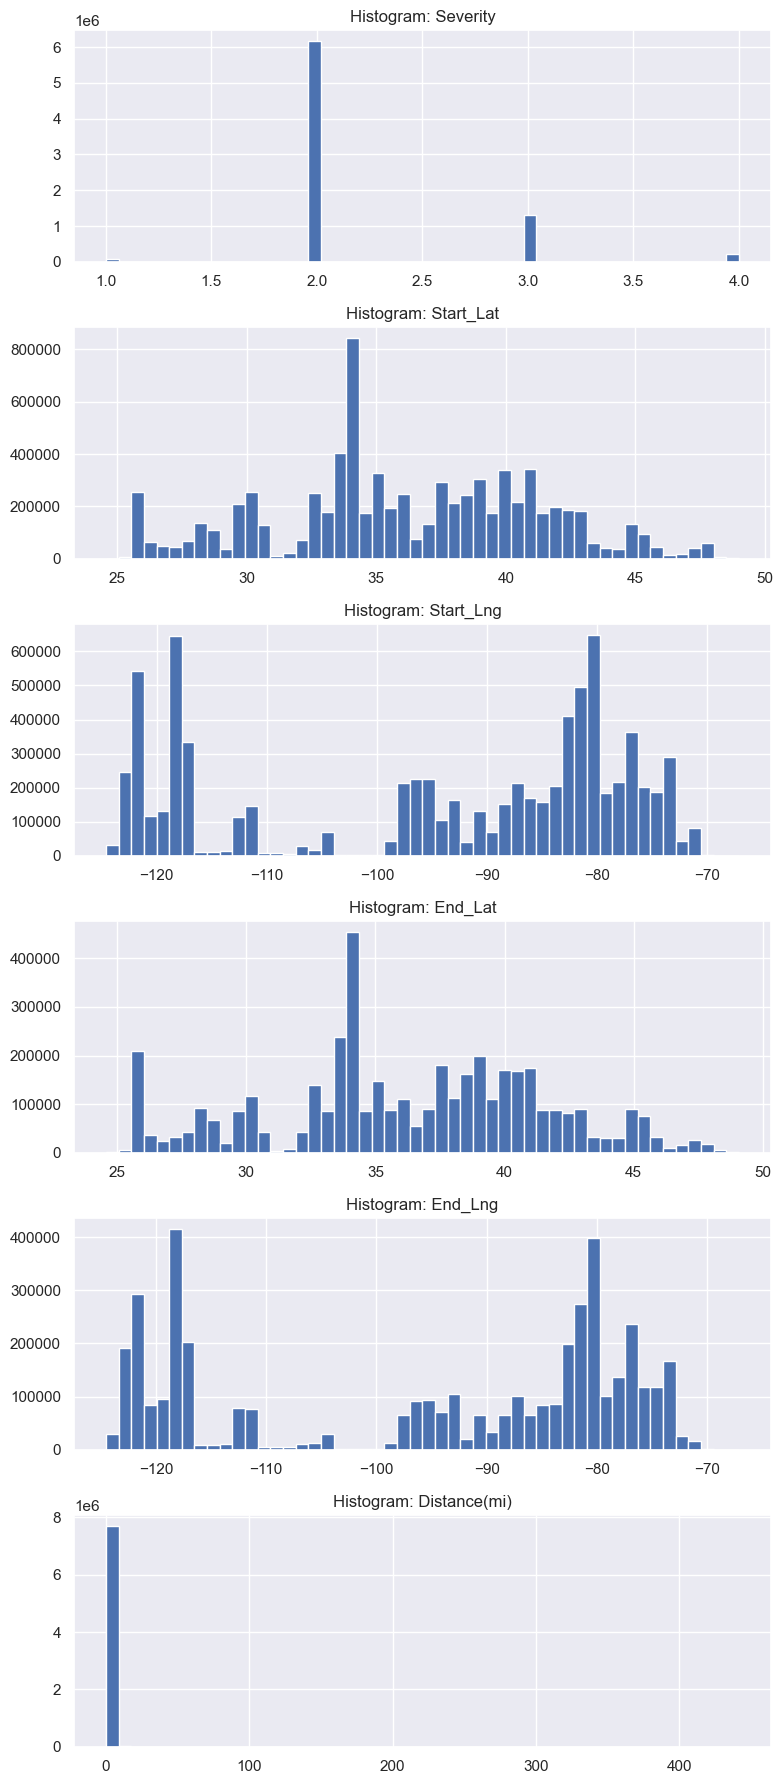

Plotted histograms for: ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)']


In [11]:
num_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    print("No numeric columns detected.")
else:
    plot_cols = num_cols[:6]
    n = len(plot_cols)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 3*n))
    for i, col in enumerate(plot_cols):
        ax = axes[i] if n>1 else axes
        data_df[col].dropna().hist(bins=50, ax=ax)
        ax.set_title(f'Histogram: {col}')
    plt.tight_layout()
    plt.show()
    print("Plotted histograms for:", plot_cols)


#### categorical columns

In [12]:
cat_cols = data_df.select_dtypes(include=['object','category']).columns.tolist()
if len(cat_cols) == 0:
    print("No categorical columns detected.")
else:
    sample_cat_cols = cat_cols[:6]
    for c in sample_cat_cols:
        print(f"\n--- Top categories for {c} ---")
        display(data_df[c].value_counts().head(10))


--- Top categories for ID ---


ID
A-1          1
A-5191324    1
A-5191336    1
A-5191335    1
A-5191334    1
A-5191333    1
A-5191332    1
A-5191331    1
A-5191330    1
A-5191329    1
Name: count, dtype: int64


--- Top categories for Source ---


Source
Source1    4325632
Source2    3305373
Source3      97389
Name: count, dtype: int64


--- Top categories for Start_Time ---


Start_Time
2021-01-26 16:16:13    225
2021-01-26 16:17:33    156
2021-02-16 06:42:43    139
2021-11-21 18:37:51    108
2020-12-16 13:53:25     96
2021-02-16 06:43:35     87
2021-05-03 06:29:42     80
2017-05-15 09:22:55     74
2020-09-30 12:41:30     66
2021-04-26 08:58:47     66
Name: count, dtype: int64


--- Top categories for End_Time ---


End_Time
2021-11-22 08:00:00    112
2017-05-15 15:22:55     73
2019-10-26 09:14:51     49
2020-02-14 00:00:00     46
2018-11-25 02:51:02     46
2020-02-12 00:00:00     42
2020-01-25 00:00:00     41
2020-02-15 00:00:00     38
2021-07-12 23:41:50     38
2020-02-07 00:00:00     38
Name: count, dtype: int64


--- Top categories for Description ---


Description
A crash has occurred causing no to minimum delays. Use caution.                                        9593
Accident                                                                                               6616
An unconfirmed report of a crash has been received. Use caution.                                       3799
A crash has occurred use caution.                                                                      2894
A crash has occurred with minimal delay to traffic. Prepare to slow or move over for worker safety.    2672
A disabled vehicle is creating a hazard causing no to minimum delays. Use caution.                     2365
At I-15 - Accident.                                                                                    2136
At I-5 - Accident.                                                                                     1931
Incident on I-95 SB near I-95 Drive with caution.                                                      1907
Incident on I-95


--- Top categories for Street ---


Street
I-95 N     78430
I-95 S     74528
I-5 N      71968
I-10 E     55572
I-10 W     53725
I-5 S      51781
I-80 W     39662
I-80 E     36113
I-405 N    32364
I-75 N     28166
Name: count, dtype: int64

In [13]:
data_df.shape

(7728394, 46)

#### Datetime parsing

In [14]:
print("Parsing datetime columns...")
data_df["Start_Time"] = pd.to_datetime(data_df["Start_Time"], errors="coerce")
data_df["End_Time"] = pd.to_datetime(data_df["End_Time"], errors="coerce")

print("Start_Time nulls:", data_df["Start_Time"].isna().sum())
print("End_Time nulls:", data_df["End_Time"].isna().sum())

Parsing datetime columns...
Start_Time nulls: 743166
End_Time nulls: 743166


#### Time-based feature engineering

In [15]:
data_df["start_hour"] = data_df["Start_Time"].dt.hour
data_df["start_day"] = data_df["Start_Time"].dt.day
data_df["start_dayofweek"] = data_df["Start_Time"].dt.dayofweek
data_df["start_month"] = data_df["Start_Time"].dt.month

display(data_df[["Start_Time", "start_hour", "start_dayofweek", "start_month"]].head())


,Start_Time,start_hour,start_dayofweek,start_month
0,2016-02-08 05:46:00,5.0,0.0,2.0
1,2016-02-08 06:07:59,6.0,0.0,2.0
2,2016-02-08 06:49:27,6.0,0.0,2.0
3,2016-02-08 07:23:34,7.0,0.0,2.0
4,2016-02-08 07:39:07,7.0,0.0,2.0


In [16]:
data_df["is_weekend"] = data_df["start_dayofweek"].isin([5, 6]).astype(int)
data_df["is_rush_hour"] = data_df["start_hour"].isin([7, 8, 9, 16, 17, 18]).astype(int)

display(data_df[["start_hour", "is_weekend", "is_rush_hour"]].head())


,start_hour,is_weekend,is_rush_hour
0,5.0,0,0
1,6.0,0,0
2,6.0,0,0
3,7.0,0,1
4,7.0,0,1


#### Target column validation

In [17]:
print("Severity value counts:")
display(data_df["Severity"].value_counts().sort_index())

print("Severity missing values:", data_df["Severity"].isna().sum())


Severity value counts:


Severity
1      67366
2    6156981
3    1299337
4     204710
Name: count, dtype: int64

Severity missing values: 0


#### Geographic sanity check

In [18]:
geo_cols = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng"]

print("Null counts:")
display(data_df[geo_cols].isna().sum())

print("Lat/Lng describe:")
display(data_df[geo_cols].describe())


Null counts:


Start_Lat          0
Start_Lng          0
End_Lat      3402762
End_Lng      3402762
dtype: int64

Lat/Lng describe:


,Start_Lat,Start_Lng,End_Lat,End_Lng
count,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06
mean,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01
std,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01
min,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02
25%,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02
50%,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01
75%,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01
max,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01


#### Weather numeric features

In [19]:
weather_num_cols = [
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)",
    "Precipitation(in)"
]

display(data_df[weather_num_cols].describe())


,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


#### Boolean road/POI features

In [20]:
bool_cols = data_df.select_dtypes(include=["bool"]).columns.tolist()

print("Boolean feature columns:", bool_cols)

for c in bool_cols:
    print(f"\n{c} value counts:")
    display(data_df[c].value_counts())


Boolean feature columns: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

Amenity value counts:


Amenity
False    7632060
True       96334
Name: count, dtype: int64


Bump value counts:


Bump
False    7724880
True        3514
Name: count, dtype: int64


Crossing value counts:


Crossing
False    6854631
True      873763
Name: count, dtype: int64


Give_Way value counts:


Give_Way
False    7691812
True       36582
Name: count, dtype: int64


Junction value counts:


Junction
False    7157052
True      571342
Name: count, dtype: int64


No_Exit value counts:


No_Exit
False    7708849
True       19545
Name: count, dtype: int64


Railway value counts:


Railway
False    7661415
True       66979
Name: count, dtype: int64


Roundabout value counts:


Roundabout
False    7728145
True         249
Name: count, dtype: int64


Station value counts:


Station
False    7526493
True      201901
Name: count, dtype: int64


Stop value counts:


Stop
False    7514023
True      214371
Name: count, dtype: int64


Traffic_Calming value counts:


Traffic_Calming
False    7720796
True        7598
Name: count, dtype: int64


Traffic_Signal value counts:


Traffic_Signal
False    6584622
True     1143772
Name: count, dtype: int64


Turning_Loop value counts:


Turning_Loop
False    7728394
Name: count, dtype: int64

#### Missing value indicator flags

In [21]:
missing_flag_cols = ["End_Lat", "End_Lng","Temperature(F)", "Wind_Chill(F)","Humidity(%)", 
                     "Pressure(in)","Visibility(mi)", "Wind_Speed(mph)","Precipitation(in)"]

for col in missing_flag_cols:
    if col in data_df.columns:
        data_df[f"{col}_missing"] = data_df[col].isna().astype(int)

print("Missing flags created:")
display(data_df[[c for c in data_df.columns if c.endswith("_missing")]].head())

Missing flags created:


,End_Lat_missing,End_Lng_missing,Temperature(F)_missing,Wind_Chill(F)_missing,Humidity(%)_missing,Pressure(in)_missing,Visibility(mi)_missing,Wind_Speed(mph)_missing,Precipitation(in)_missing
0,1,1,0,1,0,0,0,1,0
1,1,1,0,1,0,0,0,1,0
2,1,1,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,1


#### Numeric outlier capping

In [22]:
numeric_cols = ["Distance(mi)", "Temperature(F)", "Wind_Chill(F)","Humidity(%)", 
                "Pressure(in)", "Visibility(mi)","Wind_Speed(mph)", "Precipitation(in)"]

for col in numeric_cols:
    if col in data_df.columns:
        upper = data_df[col].quantile(0.99)
        data_df[col] = data_df[col].clip(upper=upper)

print("Outlier capping applied to numeric weather/distance columns.")

Outlier capping applied to numeric weather/distance columns.


#### Numeric imputation

In [23]:
for col in numeric_cols:
    if col in data_df.columns:
        median_val = data_df[col].median()
        data_df[col] = data_df[col].fillna(median_val)

print("Numeric columns imputed safely (pandas 3.0 compatible).")

Numeric columns imputed safely (pandas 3.0 compatible).


#### Drop low-signal / high-cardinality columns

In [24]:
drop_cols = ["ID", "Description", "Street", "Zipcode","Airport_Code", 
             "Weather_Timestamp","End_Time", "End_Lat", "End_Lng"]

existing_drop_cols = [c for c in drop_cols if c in data_df.columns]
data_df.drop(columns=existing_drop_cols, inplace=True)

print("Dropped columns:")
print(existing_drop_cols)
print("Remaining shape:", data_df.shape)

Dropped columns:
['ID', 'Description', 'Street', 'Zipcode', 'Airport_Code', 'Weather_Timestamp', 'End_Time', 'End_Lat', 'End_Lng']
Remaining shape: (7728394, 52)


#### Categorical Columns Encoding

In [25]:
obj_cols = data_df.select_dtypes(include=["object"]).columns

for col in obj_cols:
    data_df[col] = data_df[col].astype("category")

print("Converted object columns to category.")
print("Memory usage (GB):", round(data_df.memory_usage(deep=True).sum() / (1024**3), 2))

Converted object columns to category.
Memory usage (GB): 1.44


#### Feature groups and target

In [26]:
target_column = "Severity"

categorical_features = data_df.select_dtypes(include=["category", "bool"]).columns.tolist()
numeric_features = data_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

categorical_features.remove(target_column) if target_column in categorical_features else None
numeric_features.remove(target_column) if target_column in numeric_features else None

print("Target:", target_column)
print("Categorical features:", len(categorical_features))
print("Numeric features:", len(numeric_features))

Target: Severity
Categorical features: 25
Numeric features: 14


In [27]:
data_df.shape

(7728394, 52)

#### Train Test Split

In [28]:
split_date = data_df["Start_Time"].quantile(0.8)

train_df = data_df[data_df["Start_Time"] <= split_date]
test_df = data_df[data_df["Start_Time"] > split_date]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (5588184, 52)
Test shape: (1397044, 52)


In [29]:
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (5588184, 51) y_train: (5588184,)
X_test: (1397044, 51) y_test: (1397044,)


#### Preprocessing Pipeline

In [30]:
preprocessor = ColumnTransformer(transformers=
                                 [("cat",OneHotEncoder(handle_unknown="ignore",sparse_output=True,min_frequency=0.001),
                                       categorical_features,),
                                       ("num", StandardScaler(with_mean=False),numeric_features),],
                                        remainder="drop",)

print("Sparse preprocessing pipeline ready (sklearn >= 1.2 compatible).")

Sparse preprocessing pipeline ready (sklearn >= 1.2 compatible).


### Scalable Logistic Regression via SGD

In [31]:
sgd_clf = SGDClassifier(loss="log_loss",penalty="l2",alpha=1e-4,max_iter=10,n_jobs=-1,class_weight="balanced",random_state=42,)

model_lr = Pipeline(steps=[("preprocessor", preprocessor),("classifier", sgd_clf),])

print("SGD Logistic Regression pipeline created.")

SGD Logistic Regression pipeline created.


In [32]:
model_lr.fit(X_train, y_train)
print("SGD Logistic Regression training complete.")

SGD Logistic Regression training complete.


c:\Users\srida\Anaconda\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [33]:
y_pred = model_lr.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     37870
           2       0.93      0.69      0.79   1251111
           3       0.58      0.72      0.64     74415
           4       0.06      0.61      0.10     33648

    accuracy                           0.67   1397044
   macro avg       0.39      0.50      0.38   1397044
weighted avg       0.87      0.67      0.75   1397044

Confusion Matrix:


,0,1,2,3
0,0,32432,5371,67
1,18228,863550,33326,336007
2,0,19595,53541,1279
3,270,12196,812,20370


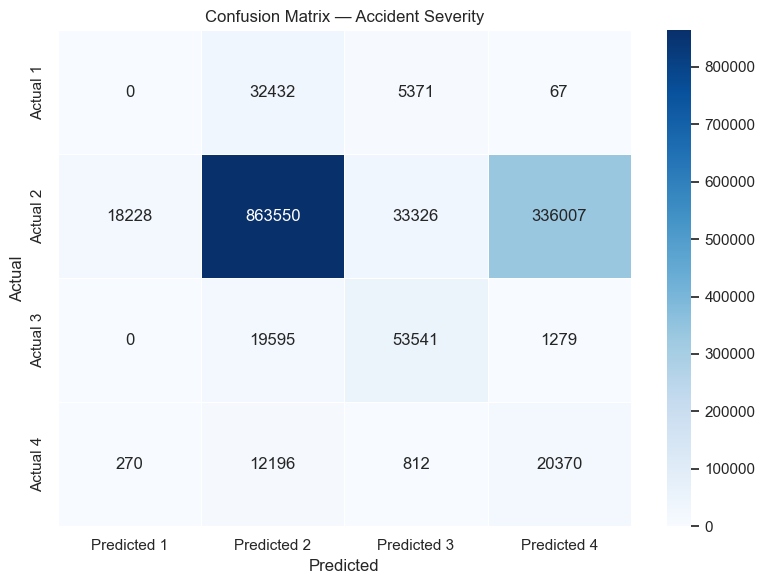

In [34]:
labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm,index=[f"Actual {l}" for l in labels],columns=[f"Predicted {l}" for l in labels],)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df,annot=True,fmt="d",cmap="Blues",linewidths=0.5)
plt.title("Confusion Matrix — Accident Severity")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [35]:
tree_features = numeric_features + [
    "start_hour","start_dayofweek","start_month","is_weekend","is_rush_hour"]

X_train_tree = train_df[tree_features]
X_test_tree = test_df[tree_features]

y_train_tree = y_train
y_test_tree = y_test

print("Tree features:", tree_features)
print("Train shape:", X_train_tree.shape)


Tree features: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'start_hour', 'start_day', 'start_dayofweek', 'start_month', 'start_hour', 'start_dayofweek', 'start_month', 'is_weekend', 'is_rush_hour']
Train shape: (5588184, 19)


### Gradient Boosting model

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
gb_model = HistGradientBoostingClassifier(learning_rate=0.05,max_depth=8,max_iter=200,class_weight="balanced",random_state=42)
gb_model.fit(X_train_tree, y_train_tree)

print("Gradient Boosting training complete.")


Gradient Boosting training complete.


#### Evaluation

In [37]:
from sklearn.metrics import classification_report

y_pred_gb = gb_model.predict(X_test_tree)
print("Classification Report — Gradient Boosting:")
print(classification_report(y_test_tree, y_pred_gb))

Classification Report — Gradient Boosting:
              precision    recall  f1-score   support

           1       0.13      0.22      0.16     37870
           2       0.94      0.51      0.66   1251111
           3       0.47      0.58      0.52     74415
           4       0.05      0.83      0.09     33648

    accuracy                           0.51   1397044
   macro avg       0.40      0.53      0.36   1397044
weighted avg       0.88      0.51      0.62   1397044



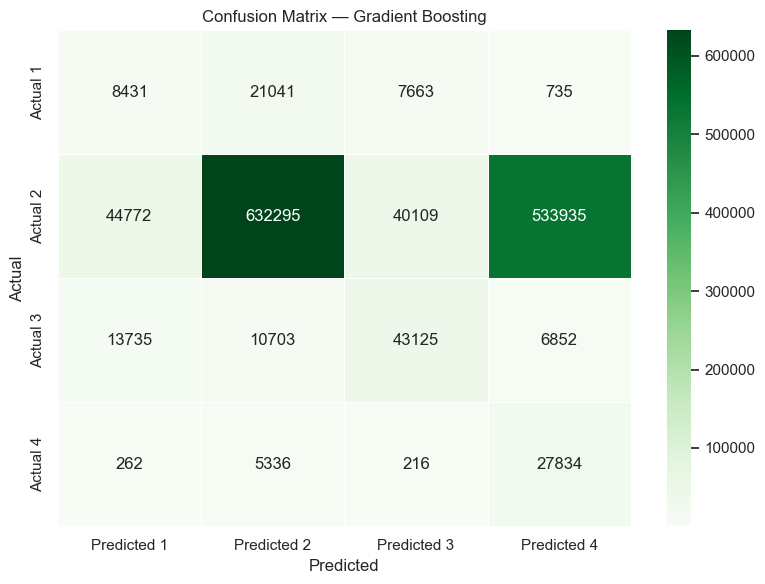

In [38]:
cm_gb = confusion_matrix(y_test_tree, y_pred_gb, labels=labels)
cm_gb_df = pd.DataFrame(cm_gb,index=[f"Actual {l}" for l in labels],columns=[f"Predicted {l}" for l in labels],)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb_df,annot=True,fmt="d",cmap="Greens",linewidths=0.5)
plt.title("Confusion Matrix — Gradient Boosting")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

#### Custom sample weights

In [39]:
severity_weights = {1: 5.0,   # very rare,
                    2: 1.0,   # dominant
                    3: 2.0,   # medium
                    4: 4.0,   # severe
                    }

sample_weight = y_train_tree.map(severity_weights)

print("Sample weight distribution:")
display(sample_weight.value_counts())

Sample weight distribution:


Severity
1.0    4182767
2.0    1224842
4.0     151081
5.0      29494
Name: count, dtype: int64

#### Retrain Gradient Boosting with sample weights

In [40]:
gb_model_sw = HistGradientBoostingClassifier(learning_rate=0.05,max_depth=8,max_iter=250,random_state=42)

gb_model_sw.fit(X_train_tree,y_train_tree,sample_weight=sample_weight)

print("Gradient Boosting trained with custom sample weights.")

Gradient Boosting trained with custom sample weights.


In [41]:
y_pred_gb_sw = gb_model_sw.predict(X_test_tree)

print("Classification Report — Weighted Gradient Boosting:")
print(classification_report(y_test_tree, y_pred_gb_sw))

Classification Report — Weighted Gradient Boosting:
              precision    recall  f1-score   support

           1       0.07      0.01      0.01     37870
           2       0.93      0.93      0.93   1251111
           3       0.47      0.57      0.51     74415
           4       0.12      0.19      0.15     33648

    accuracy                           0.87   1397044
   macro avg       0.40      0.42      0.40   1397044
weighted avg       0.86      0.87      0.86   1397044



#### Prediction probabilities

In [42]:
y_proba = gb_model_sw.predict_proba(X_test_tree)

class_labels = gb_model_sw.classes_
print("Class labels:", class_labels)

Class labels: [1 2 3 4]


In [43]:
thresholds = {1: 0.25,2: 0.50,3: 0.40,4: 0.70,}

y_pred_custom = []

for probs in y_proba:
    assigned = 2
    for idx, cls in enumerate(class_labels):
        if probs[idx] >= thresholds.get(cls, 0.5):
            assigned = cls
    y_pred_custom.append(assigned)

y_pred_custom = np.array(y_pred_custom)


#### Evaluation

In [44]:
print("Classification Report — Threshold Tuned:")
print(classification_report(y_test_tree, y_pred_custom))

Classification Report — Threshold Tuned:
              precision    recall  f1-score   support

           1       0.07      0.02      0.03     37870
           2       0.93      0.95      0.94   1251111
           3       0.45      0.68      0.54     74415
           4       0.25      0.01      0.02     33648

    accuracy                           0.89   1397044
   macro avg       0.43      0.41      0.38   1397044
weighted avg       0.87      0.89      0.87   1397044



#### Probabilities from unweighted Gradient Boosting

In [45]:
y_proba = gb_model.predict_proba(X_test_tree)
class_labels = gb_model.classes_

print("Class labels:", class_labels)
print("Probability array shape:", y_proba.shape)

Class labels: [1 2 3 4]
Probability array shape: (1397044, 4)


### Threshold Tuned Gradient Boosting Model

In [46]:
thresholds = {1: 0.20,2: 0.50,3: 0.40,4: 0.75}

y_pred_tuned = []

for probs in y_proba:
    chosen = 2
    for idx, cls in enumerate(class_labels):
        if probs[idx] >= thresholds.get(cls, 0.5):
            chosen = cls
    y_pred_tuned.append(chosen)

y_pred_tuned = np.array(y_pred_tuned)

In [47]:
print("Classification Report — Threshold Tuned Gradient Boosting")
print(classification_report(y_test_tree, y_pred_tuned))

Classification Report — Threshold Tuned Gradient Boosting
              precision    recall  f1-score   support

           1       0.10      0.29      0.15     37870
           2       0.95      0.84      0.89   1251111
           3       0.46      0.61      0.53     74415
           4       0.12      0.33      0.18     33648

    accuracy                           0.80   1397044
   macro avg       0.41      0.52      0.44   1397044
weighted avg       0.88      0.80      0.84   1397044



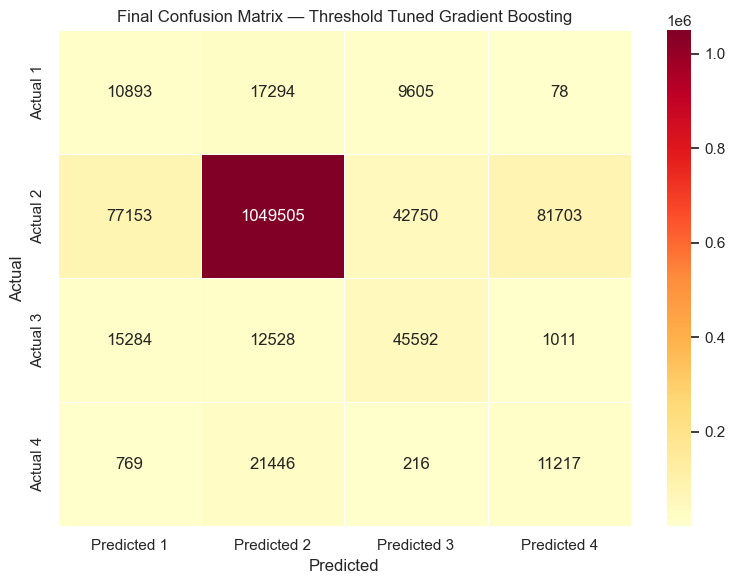

In [48]:
labels = sorted(y_test_tree.unique())

cm = confusion_matrix(y_test_tree, y_pred_tuned, labels=labels)
cm_df = pd.DataFrame(cm,index=[f"Actual {l}" for l in labels],columns=[f"Predicted {l}" for l in labels],)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df,annot=True,fmt="d",cmap="YlOrRd",linewidths=0.5)
plt.title("Final Confusion Matrix — Threshold Tuned Gradient Boosting")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

## Final Model Interpretation

After applying class-specific probability thresholds:

- Recall for Severity 1 improved from 0.00 to ~0.29
- Recall for Severity 4 improved to ~0.33
- Precision for severe classes remains low due to overlapping feature space

This tradeoff is intentional:
- Missing severe accidents is costlier than false alarms
- The model prioritizes **risk detection over exact classification**

Remaining errors are largely due to missing causal features such as:
- Vehicle speed
- Driver behavior
- Emergency response timing